In [29]:
# Importing the Required Libraries 

import pandas as pd 
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import random
import matplotlib.image as img
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torchvision import transforms as T, datasets 
from torch.utils.data import DataLoader 
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# from helper import show_grid
%matplotlib inline

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("The device we are on :{}".format(device))

The device we are on :cuda


In [31]:
import os
os.listdir('../input/facial-expression-dataset-image-folders-fer2013/data')
uni_path = '../input/facial-expression-dataset-image-folders-fer2013/data'

# os.listdir('C:/Users/shukl/OneDrive/Desktop/ML_project/Dataset')
# uni_path = 'C:/Users/shukl/OneDrive/Desktop/ML_project/Dataset'

In [32]:
# Getting the path to the dataset

train_path=uni_path+'/train'
val_path=uni_path+'/val'
test_path=uni_path+'/test'

print (type(train_path))

<class 'str'>


In [33]:
# Image Transformation and Augumentation 
train_transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize(size=(48,48)),
    T.RandomRotation(degrees = (-20, +20)),
    T.ToTensor()
])

valid_transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize(size=(48,48)),
    T.ToTensor()
])

test_transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.Resize(size=(48,48)),
    T.ToTensor()
])

train_ds = datasets.ImageFolder(train_path, transform = train_transform)
valid_ds = datasets.ImageFolder(val_path, transform = valid_transform)
test_ds = datasets.ImageFolder(test_path, transform = test_transform)
print (len(train_ds))
print (len(valid_ds))
print (len(test_ds))

28709
3589
3589


In [34]:
# Definging the batch size 
batch_size = 64

# Loading the Dataset 
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size)
test_dl = DataLoader(test_ds, batch_size = batch_size)
print (len(train_dl))
print (len(valid_dl))
print (len(test_dl))

449
57
57


In [35]:
# Building The CNN model

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = Sequential(
            Linear(16 * 6 * 6, 7)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [36]:
model = Net()

In [37]:
# Building Trainer using Train Loader and Validation Loader 

class Trainer():
    
    def __init__(self, criterion, optimizer, schedular):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
        
    def train_batch_loop(self, model, trainloader):
        
        train_acc = 0.0
        train_loss = 0.0
        
        for images, labels in tqdm(trainloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss = train_loss + loss.item()
            
            softmax = torch.exp(logits).cpu()
            
            prob = list(softmax.detach().numpy())
            
            logits = np.argmax(prob, axis=1)
            labels = labels.detach().cpu().numpy()
            train_acc = train_acc + accuracy_score(logits, labels)
            
        return train_acc/ len(trainloader), train_loss/ len(trainloader)
    
    def valid_batch_loop(self, model, validloader):
        
        valid_acc = 0.0
        valid_loss = 0.0
        
        for images, labels in tqdm(validloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
                        
            valid_loss = valid_loss + loss.item()
            softmax = torch.exp(logits).cpu()
            prob = list(softmax.detach().numpy())
            logits = np.argmax(prob, axis=1)
            labels = labels.detach().cpu().numpy()
            valid_acc = valid_acc + accuracy_score(logits, labels)
            _
        return valid_acc/ len(validloader), valid_loss/ len(validloader)
    
    def test_batch_loop(self, model, testloader):
        
        test_acc = 0.0
        test_loss = 0.0
        
        test_predictions = []
        test_labels = []
        
        for images, labels in tqdm(testloader):
            
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits, labels)
                        
            test_loss = test_loss + loss.item()
            softmax = torch.exp(logits).cpu()
            prob = list(softmax.detach().numpy())
            logits = np.argmax(prob, axis=1)
            labels = labels.detach().cpu().numpy()
            test_acc = test_acc + accuracy_score(logits, labels)
            test_predictions.append(logits)
            test_labels.append(labels)
            _
        return test_predictions , test_labels ,test_acc/ len(testloader), test_loss/ len(testloader)
    
    def fit(self,model, trainloader, validloader, epochs):
        
       
        model = model.to(device)
        valid_min_loss = np.Inf
        
        training_loss = []
        validation_loss = []
        train_acc = []
        val_acc = []
        
        
        for i in range(epochs):            
            
            # Training of Model
            model.train()
            avg_train_acc, avg_train_loss = self.train_batch_loop(model, trainloader)
            
            # Storing train loss
            training_loss.append(avg_train_loss)
            train_acc.append(avg_train_acc)
            
            # Validation of model
            model.eval()
            avg_valid_acc, avg_valid_loss = self.valid_batch_loop(model, validloader)
            
            # Storing Validation loss
            validation_loss.append(avg_valid_loss)
            val_acc.append(avg_valid_acc)

            
            # Getting Train and Validation Accuracies
#             train_acc = avg_train_acc
#             val_acc = avg_valid_acc
            
            print ("Epoch:{}".format(i), "Train Loss:{}".format(avg_train_loss), "Validation Loss:{}".format(avg_valid_loss))
            
        return train_acc, val_acc, training_loss, validation_loss
                    
            
            
            

In [38]:
# Training The Model 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01)
schedular = None 

trainer = Trainer(criterion, optimizer, schedular)
trn_acc, val_acc, training_ls , validation_ls = trainer.fit(model, train_dl, valid_dl, epochs = 50)


100%|██████████| 57/57 [00:02<00:00, 20.04it/s]


Epoch:0 Train Loss:1.743596076434333 Validation Loss:1.6958199132952774


100%|██████████| 57/57 [00:02<00:00, 19.14it/s]


Epoch:1 Train Loss:1.6571394165268454 Validation Loss:1.6285883815664994


100%|██████████| 57/57 [00:02<00:00, 19.99it/s]


Epoch:2 Train Loss:1.6221877097552497 Validation Loss:1.5976812483971579


100%|██████████| 57/57 [00:02<00:00, 19.64it/s]


Epoch:3 Train Loss:1.5951960915181047 Validation Loss:1.5613328720393933


100%|██████████| 57/57 [00:02<00:00, 19.24it/s]


Epoch:4 Train Loss:1.570744712793482 Validation Loss:1.875020100882179


100%|██████████| 57/57 [00:02<00:00, 19.11it/s]


Epoch:5 Train Loss:1.553332845192975 Validation Loss:1.52201090047234


100%|██████████| 57/57 [00:02<00:00, 19.87it/s]


Epoch:6 Train Loss:1.5397314558050414 Validation Loss:1.536952441198784


100%|██████████| 57/57 [00:02<00:00, 19.66it/s]


Epoch:7 Train Loss:1.5308406392821756 Validation Loss:1.554647187391917


100%|██████████| 57/57 [00:03<00:00, 18.54it/s]


Epoch:8 Train Loss:1.522194157464467 Validation Loss:1.4910203887705218


100%|██████████| 57/57 [00:03<00:00, 17.19it/s]


Epoch:9 Train Loss:1.5137590552225941 Validation Loss:1.4749047076492978


100%|██████████| 57/57 [00:03<00:00, 17.31it/s]


Epoch:10 Train Loss:1.5046380885725297 Validation Loss:1.470360859444267


100%|██████████| 57/57 [00:02<00:00, 19.08it/s]


Epoch:11 Train Loss:1.4981959166133856 Validation Loss:1.564316219405124


100%|██████████| 57/57 [00:03<00:00, 18.70it/s]


Epoch:12 Train Loss:1.4937736008374356 Validation Loss:1.6044637231450332


100%|██████████| 57/57 [00:02<00:00, 19.11it/s]


Epoch:13 Train Loss:1.4867777577487291 Validation Loss:1.5970486465253328


100%|██████████| 57/57 [00:02<00:00, 19.39it/s]


Epoch:14 Train Loss:1.4822429941597919 Validation Loss:1.577554834516425


100%|██████████| 57/57 [00:03<00:00, 17.11it/s]


Epoch:15 Train Loss:1.4768566233012619 Validation Loss:1.5744033257166545


100%|██████████| 57/57 [00:03<00:00, 16.62it/s]


Epoch:16 Train Loss:1.4737710450964674 Validation Loss:1.5036229804942483


100%|██████████| 57/57 [00:03<00:00, 18.75it/s]


Epoch:17 Train Loss:1.4698988156754085 Validation Loss:1.450594729498813


100%|██████████| 57/57 [00:02<00:00, 19.14it/s]


Epoch:18 Train Loss:1.4703268773837186 Validation Loss:1.5410848824601424


100%|██████████| 57/57 [00:03<00:00, 16.28it/s]


Epoch:19 Train Loss:1.4657837970219636 Validation Loss:1.433907989870038


100%|██████████| 57/57 [00:03<00:00, 15.25it/s]


Epoch:20 Train Loss:1.4623238196086246 Validation Loss:1.641920539893602


100%|██████████| 57/57 [00:03<00:00, 15.36it/s]


Epoch:21 Train Loss:1.4631890947940887 Validation Loss:1.4586094994294017


100%|██████████| 57/57 [00:03<00:00, 16.02it/s]


Epoch:22 Train Loss:1.4605874157695302 Validation Loss:1.6181142220371647


100%|██████████| 57/57 [00:03<00:00, 16.78it/s]


Epoch:23 Train Loss:1.460526710363698 Validation Loss:1.6056245283076638


100%|██████████| 57/57 [00:03<00:00, 16.49it/s]


Epoch:24 Train Loss:1.454503550030341 Validation Loss:1.4547112782796223


100%|██████████| 57/57 [00:03<00:00, 16.54it/s]


Epoch:25 Train Loss:1.4509214967290118 Validation Loss:1.4272502232016178


100%|██████████| 57/57 [00:03<00:00, 16.03it/s]


Epoch:26 Train Loss:1.4521991832219148 Validation Loss:1.4260320433399134


100%|██████████| 57/57 [00:03<00:00, 15.42it/s]


Epoch:27 Train Loss:1.449961055360552 Validation Loss:1.4768945229680914


100%|██████████| 57/57 [00:03<00:00, 16.54it/s]


Epoch:28 Train Loss:1.4493868340362686 Validation Loss:1.4398655849590636


100%|██████████| 57/57 [00:03<00:00, 16.99it/s]


Epoch:29 Train Loss:1.4500315874350362 Validation Loss:1.4384894611542685


100%|██████████| 57/57 [00:03<00:00, 16.15it/s]


Epoch:30 Train Loss:1.4465855237901344 Validation Loss:1.4182595443307309


100%|██████████| 57/57 [00:03<00:00, 15.45it/s]


Epoch:31 Train Loss:1.4453988168181184 Validation Loss:1.5197482767858004


100%|██████████| 57/57 [00:03<00:00, 16.72it/s]


Epoch:32 Train Loss:1.4503250039765458 Validation Loss:1.4241572085179781


100%|██████████| 57/57 [00:03<00:00, 16.77it/s]


Epoch:33 Train Loss:1.4454450421450133 Validation Loss:1.432173974681319


100%|██████████| 57/57 [00:03<00:00, 16.94it/s]


Epoch:34 Train Loss:1.4397866147132652 Validation Loss:1.453789812431001


100%|██████████| 57/57 [00:03<00:00, 17.07it/s]


Epoch:35 Train Loss:1.4406647010476128 Validation Loss:1.400099542057305


100%|██████████| 57/57 [00:03<00:00, 16.97it/s]


Epoch:36 Train Loss:1.4394595110602262 Validation Loss:1.4334431928500795


100%|██████████| 57/57 [00:03<00:00, 16.52it/s]


Epoch:37 Train Loss:1.4369561539460927 Validation Loss:1.4116077674062628


100%|██████████| 57/57 [00:03<00:00, 16.73it/s]


Epoch:38 Train Loss:1.4379588463789637 Validation Loss:1.4114150007565816


100%|██████████| 57/57 [00:03<00:00, 16.29it/s]


Epoch:39 Train Loss:1.4413469015622724 Validation Loss:1.4442915707303767


100%|██████████| 57/57 [00:03<00:00, 16.71it/s]


Epoch:40 Train Loss:1.437529494608431 Validation Loss:1.3994314837874027


100%|██████████| 57/57 [00:03<00:00, 16.85it/s]


Epoch:41 Train Loss:1.4416508377262107 Validation Loss:1.406581319215005


100%|██████████| 57/57 [00:03<00:00, 16.61it/s]


Epoch:42 Train Loss:1.4360714155209888 Validation Loss:1.4678435827556409


100%|██████████| 57/57 [00:03<00:00, 16.77it/s]


Epoch:43 Train Loss:1.434521743343243 Validation Loss:1.4761582518878735


100%|██████████| 57/57 [00:03<00:00, 16.25it/s]


Epoch:44 Train Loss:1.4378550217252533 Validation Loss:1.402321273820442


100%|██████████| 57/57 [00:03<00:00, 16.21it/s]


Epoch:45 Train Loss:1.4369366102600947 Validation Loss:1.423031979485562


100%|██████████| 57/57 [00:03<00:00, 16.33it/s]


Epoch:46 Train Loss:1.4337163730825242 Validation Loss:1.4167261175942003


100%|██████████| 57/57 [00:02<00:00, 19.56it/s]


Epoch:47 Train Loss:1.4327188042596082 Validation Loss:1.4624963695542854


100%|██████████| 57/57 [00:03<00:00, 17.26it/s]


Epoch:48 Train Loss:1.4304945036138352 Validation Loss:1.4599056510548842


100%|██████████| 57/57 [00:03<00:00, 18.62it/s]

Epoch:49 Train Loss:1.4363634243839833 Validation Loss:1.4309908799957811


In [39]:
print ("The list of the Training loss:", training_ls)
print ("The List of the Validation Loss:", validation_ls)

The list of the Training loss: [1.743596076434333, 1.6571394165268454, 1.6221877097552497, 1.5951960915181047, 1.570744712793482, 1.553332845192975, 1.5397314558050414, 1.5308406392821756, 1.522194157464467, 1.5137590552225941, 1.5046380885725297, 1.4981959166133856, 1.4937736008374356, 1.4867777577487291, 1.4822429941597919, 1.4768566233012619, 1.4737710450964674, 1.4698988156754085, 1.4703268773837186, 1.4657837970219636, 1.4623238196086246, 1.4631890947940887, 1.4605874157695302, 1.460526710363698, 1.454503550030341, 1.4509214967290118, 1.4521991832219148, 1.449961055360552, 1.4493868340362686, 1.4500315874350362, 1.4465855237901344, 1.4453988168181184, 1.4503250039765458, 1.4454450421450133, 1.4397866147132652, 1.4406647010476128, 1.4394595110602262, 1.4369561539460927, 1.4379588463789637, 1.4413469015622724, 1.437529494608431, 1.4416508377262107, 1.4360714155209888, 1.434521743343243, 1.4378550217252533, 1.4369366102600947, 1.4337163730825242, 1.4327188042596082, 1.430494503613835

In [40]:
print ("Train Accuracy:{}".format(trn_acc), "Validation Accuracy:{}".format(val_acc))

Train Accuracy:[0.290941205682297, 0.34894547944380905, 0.37019201829892256, 0.3829643953530368, 0.39384066694757114, 0.3998261903328718, 0.4093640898693794, 0.41177466441943056, 0.4172193839162102, 0.4220537004153374, 0.4274598582435442, 0.4261722747246133, 0.43006982483597184, 0.4338695599831457, 0.4321013663998074, 0.43575155751519895, 0.4382796981279721, 0.44155743995666047, 0.4360779209053151, 0.44150006771805217, 0.4435466577379161, 0.4409752528140613, 0.44146526816348647, 0.4442774483837958, 0.44571081382050204, 0.44650556040450246, 0.44460663335941736, 0.44572962439053754, 0.44677361102750857, 0.448260586588816, 0.45023475591404327, 0.449677963040992, 0.4454578116535243, 0.4504473153554445, 0.45174712574489856, 0.4534428986336002, 0.455888272738217, 0.4557396692349365, 0.4517659363149341, 0.4502855444531391, 0.4535472972972973, 0.4506401236983086, 0.45364887437548906, 0.4543505086378138, 0.45072571179197013, 0.45319930175164025, 0.45502486757358696, 0.45511327725275386, 0.45592

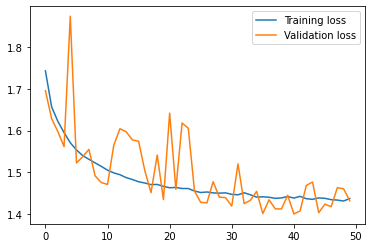

In [53]:
# Plotting Train Loss and Validation Loss
plt.plot(training_ls, label ='Training loss')
plt.plot(validation_ls, label ='Validation loss')


plt.legend()
plt.show()

In [42]:
print(trn_acc)

[0.290941205682297, 0.34894547944380905, 0.37019201829892256, 0.3829643953530368, 0.39384066694757114, 0.3998261903328718, 0.4093640898693794, 0.41177466441943056, 0.4172193839162102, 0.4220537004153374, 0.4274598582435442, 0.4261722747246133, 0.43006982483597184, 0.4338695599831457, 0.4321013663998074, 0.43575155751519895, 0.4382796981279721, 0.44155743995666047, 0.4360779209053151, 0.44150006771805217, 0.4435466577379161, 0.4409752528140613, 0.44146526816348647, 0.4442774483837958, 0.44571081382050204, 0.44650556040450246, 0.44460663335941736, 0.44572962439053754, 0.44677361102750857, 0.448260586588816, 0.45023475591404327, 0.449677963040992, 0.4454578116535243, 0.4504473153554445, 0.45174712574489856, 0.4534428986336002, 0.455888272738217, 0.4557396692349365, 0.4517659363149341, 0.4502855444531391, 0.4535472972972973, 0.4506401236983086, 0.45364887437548906, 0.4543505086378138, 0.45072571179197013, 0.45319930175164025, 0.45502486757358696, 0.45511327725275386, 0.4559230722927827, 0.

In [54]:
trainacc = [val*100 for val in trn_acc]
valacc = [val*100 for val in val_acc]

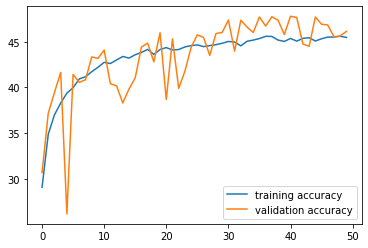

In [55]:
# Plotting Train accuracy and Validation accuracy
plt.plot(trainacc, label = 'training accuracy')
plt.plot(valacc, label = 'validation accuracy')

plt.legend()
plt.show()

In [44]:
# Checking on Test Data

model.eval()
predictions , labels ,avg_test_acc, avg_test_loss = trainer.test_batch_loop(model, test_dl)

100%|██████████| 57/57 [00:03<00:00, 17.00it/s]


In [45]:
print (avg_test_acc)
print (avg_test_loss)

0.4576754385964912
1.4321369016379641


In [62]:
from sklearn.metrics import classification_report

In [63]:
predictions = np.concatenate(predictions, axis = 0)
labels = np.concatenate(labels,axis = 0)

print(len(labels))
print(len(predictions))

print(accuracy_score(labels, predictions))
print(classification_report(labels, predictions))



ValueError: zero-dimensional arrays cannot be concatenated

In [64]:
print(accuracy_score(labels, predictions))
print(classification_report(labels, predictions))

0.45862357202563386
              precision    recall  f1-score   support

           0       0.40      0.24      0.30       491
           1       0.00      0.00      0.00        55
           2       0.34      0.17      0.23       528
           3       0.63      0.72      0.67       879
           4       0.32      0.40      0.36       594
           5       0.70      0.43      0.53       416
           6       0.38      0.62      0.47       626

    accuracy                           0.46      3589
   macro avg       0.40      0.37      0.37      3589
weighted avg       0.46      0.46      0.44      3589



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Each class accuracies
[0.23828921 0.         0.17045455 0.72241183 0.4023569  0.42548077
 0.61980831]


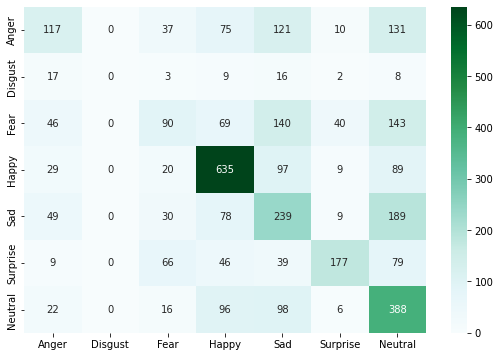

In [58]:

plt.figure(figsize = (9,6))
class_names = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral']
cm = confusion_matrix(labels , predictions)
df_cm = pd.DataFrame(cm,class_names,class_names)
ax= plt.subplot()
sns.heatmap(df_cm, annot=True, fmt='g', ax=ax , cmap = "BuGn");

print("Each class accuracies")
print((cm.diagonal()/cm.sum(axis=1)))

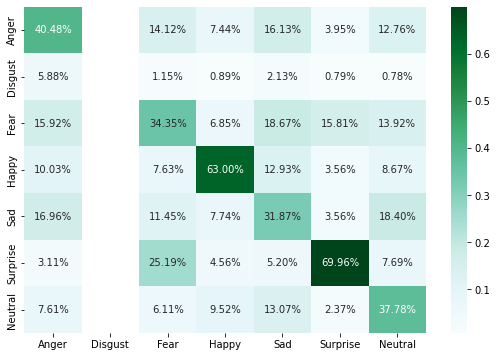

In [60]:
plt.figure(figsize = (9,6))
ax1 = plt.subplot()
sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', ax=ax1 , cmap = "BuGn");
plt.show()

In [49]:
multilabel_confusion_matrix(labels , predictions)

array([[[2926,  172],
        [ 374,  117]],

       [[3534,    0],
        [  55,    0]],

       [[2889,  172],
        [ 438,   90]],

       [[2337,  373],
        [ 244,  635]],

       [[2484,  511],
        [ 355,  239]],

       [[3097,   76],
        [ 239,  177]],

       [[2324,  639],
        [ 238,  388]]])

In [50]:
print(classification_report(labels,predictions))

              precision    recall  f1-score   support

           0       0.40      0.24      0.30       491
           1       0.00      0.00      0.00        55
           2       0.34      0.17      0.23       528
           3       0.63      0.72      0.67       879
           4       0.32      0.40      0.36       594
           5       0.70      0.43      0.53       416
           6       0.38      0.62      0.47       626

    accuracy                           0.46      3589
   macro avg       0.40      0.37      0.37      3589
weighted avg       0.46      0.46      0.44      3589



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
